## 第二章 灰度变换与空间滤波
+ 主要内容：
    + 读书笔记。
    + 代码示例。

### 1. 读书笔记
+ 一些基本概念：
    + 空间域：图像平面本身，以对图像像素直接处理作为基础。
    + 空间域变换：
        + 亮度（灰度）变换
        + 空间滤波（邻域处理、空间卷积）
    + 空间邻域：中心点位于$(x, y)$的正方形或矩形区域。
    + 亮度（灰度）变换：邻域大小为`1*1`的情况。
        + 在处理单色（灰度）图像时，亮度变换与灰度变换等价。
        + 当处理彩色空间中的彩色图像分量时，可能有不同。
        + 常见方法举例：负片变换、对数变换、伽马变换、对比度拉伸。
    + 直方图相关：
        + 直方图/归一化直方图：计算每个像素的个数/每类像素的占比。
        + 直方图均衡：
            + 原理：使用$T(r_k) = (L - 1) \sum_{j=1}^k p_r(r_j) = \frac{L - 1}{MN} \sum_{j=0}^k n_j$ 来处理原始图像。
            + 目标：如果原始图像的像素分布（即直方图）集中在某一小块区域（如暗图像、亮图像、低对比度图像），可以通过直方图均衡来增加对比度。
            + 说明：把输入图像的灰度级扩展到较宽灰度范围来实现图像增强。
        + 直方图匹配：
            + 生成具有特定直方图的图像的方法。
    + 空间滤波：
        + 线性空间滤波：直接对图像中的像素执行滤波运算。
            + 相关与卷积：
        + 非线性空间滤波：涉及滤波器包围范围的邻域内像素的非线性操作。

### 2. 代码举例
+ 常用函数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# 图像反转
def implement(img):
    if img.dtype == np.uint8:
        max_pixel_value = 255
    elif img.dtype == np.uint16:
        max_pixel_value = 65535
    else:
        raise TypeError('implement only support uint8 or uint 16, but get {}'.format(img.dtype))
    return max_pixel_value - 1 - img

# 对数变换
def imlog(img, c):
    tp_img = c * np.log(1.0+img)
    return tp_img.astype(img.dtype)

# 伽马变换
def imgamma(img, c, gamma):
    tp_img = c * np.power(img, gamma)
    return tp_img.astype(img.dtype)


# 对比度拉伸
def im_constrast_stretching(img, m, e):
    tp_img = 1.0/(np.power(m/img, e) + 1)
    return tp_img.astype(img.dtype)

In [3]:
def imhist(img):
    if img.dtype == np.uint8:
        max_bins = 256
    elif img.dtype == np.uint16:
        maxbins = 65535
    else:
        raise TypeError('imhist only support uint8 or uint16, but get {}'.format(img.dtype))
#     # 朴素的直方图实现
#     res = np.zeros(256, dtype=np.int32)
#     img = img.reshape([-1])
#     for pixel in img:
#         res[pixel] += 1
#     return res
    return np.histogram(img, bins=max_bins, range=(0, max_bins-1))[0]

def get_cdp(hist):
#     # 朴素的 cumsum 实现
#     res = np.zeros(256, dtype=np.float32)
#     tp_sum = .0
#     for i in range(256):
#         tp_sum += hist[i]
#         res[i] = tp_sum
    res = np.cumsum(hist)
    res = res / res[-1]
    return res

# 灰度范围调整
def imadjust(img, low_in, high_in, low_out, high_out, gamma):
    img = img / 255.0
    img[img < low_in] = low_in
    img[img > high_in] = high_in
    img = np.power((img - low_in)/(high_in - low_in), gamma) * (high_out - low_out) + low_out
    img = img * 255.0
    return img.astype(np.uint8)

# 自动获取上下限
def stretchlim(img, tol=None):
    if tol is None:
        tol_low = 0.01
        tol_high = 0.99
    elif isinstance(tol, int):
        tol_low = tol
        tol_high = 1 - tol
    elif isinstance(tol, (list, tuple)):
        tol_low = tol[0]
        tol_high = tol[1]
    else:
        raise TypeError('unsupport tol type {}'.format(type(tol)))
    
    nbins = 255
    if tol_low < tol_high:
        cdp = get_cdp(imhist(img))
        ilow = 0
        while True:
            if cdp[ilow] < tol_low:
                ilow += 1
                continue
            else:
                break
        
        ihigh = 0
        while True:
            if cdp[ihigh] <= tol_high:
                ihigh += 1
                continue
            else:
                break
        
        if ilow == ihigh:
            return 0, 1
        else:
            return ilow*1.0/nbins, ihigh*1.0/nbins
        
    else:
        return 0, 1

+ 图2.3

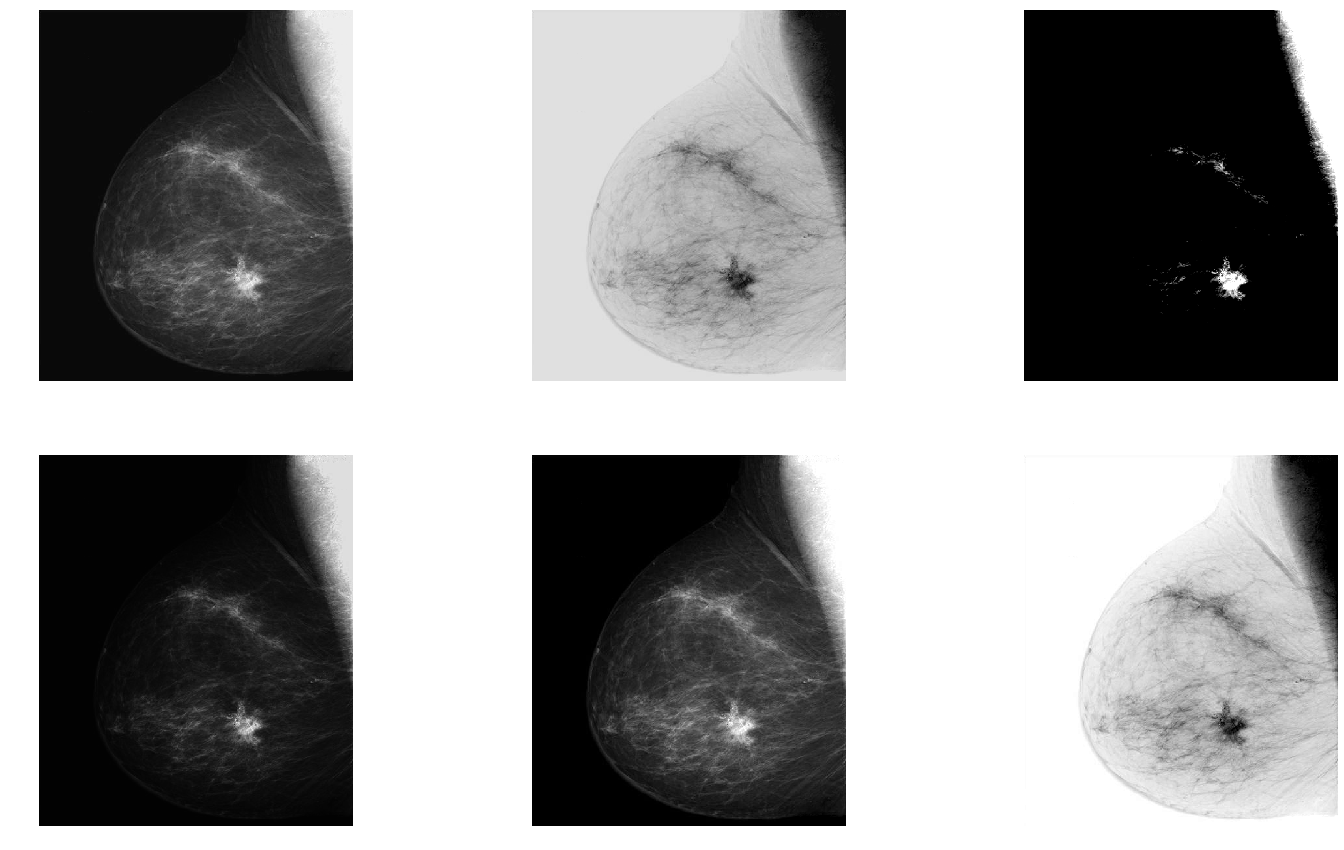

In [4]:
img = cv2.imread('./data/original_images/ch02/Fig0203(a).tif', cv2.IMREAD_ANYCOLOR)

fig = plt.figure(figsize=(25, 15))

# 原始图像
ax1 = fig.add_subplot(231)
plt.imshow(img, cmap='gray')
plt.axis('off')

# 负片
ax2 = fig.add_subplot(232)
plt.imshow(implement(img), cmap='gray')
plt.axis('off')

# 灰度扩展至范围[0.5, 0.75]
ax3 = fig.add_subplot(233)
plt.imshow(imadjust(img, 0.5, 0.75, 0, 1, 1), cmap='gray')
plt.axis('off')

# 使用gamma为2的图像增强
ax4 = fig.add_subplot(234)
plt.imshow(imadjust(img, 0, 1, 0, 1, 2), cmap='gray')
plt.axis('off')

# 使用 stretchlim 函数获取上下限
ax5 = fig.add_subplot(235)
l, h = stretchlim(img)
plt.imshow(imadjust(img, l, h, 0, 1, 1), cmap='gray')
plt.axis('off')

# 使用 stretchlim 函数获取上下限，并设置目标域为[1, 0]
ax6 = fig.add_subplot(236)
plt.imshow(imadjust(img, l, h, 1, 0, 1), cmap='gray')
plt.axis('off')

plt.show()

+ 图2.5

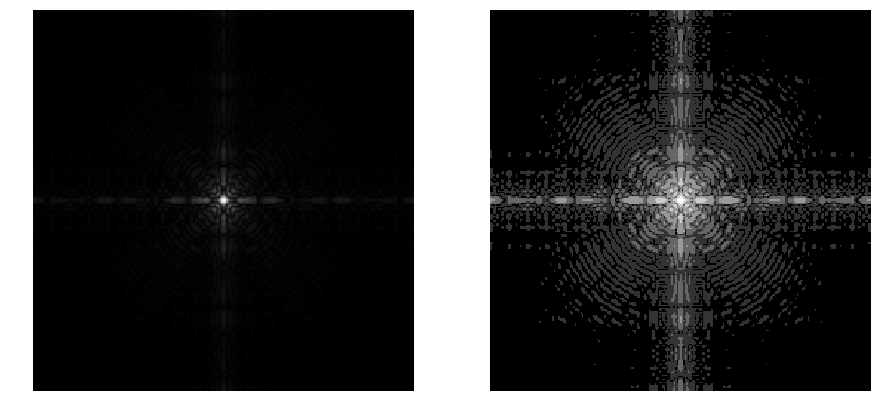

In [5]:
img = cv2.imread('./data/original_images/ch02/Fig0205(a).tif', cv2.IMREAD_ANYCOLOR)
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(121)
plt.imshow(img, cmap='gray')
plt.axis('off')

ax2 = fig.add_subplot(122)
plt.imshow(imlog(img, 1), cmap='gray')
plt.axis('off')

plt.show()

+ 实现 intrans 函数 & 图2.6

In [6]:
def intrans(img, method, *config):
    if isinstance(img.dtype, np.uint8):
        img = img / 255.0
    
    if method == 'neg':
        return implement(img)
    
    if method == 'log':
        c = 1 if config is None else config[0]
        return imlog(img, c)
    
    if method == 'gamma':
        return imgamma(img, 1, config[0])
    
    if method == 'stretch':
        if config is None:
            m = np.min(img)
            e = 4
        else:
            m = config[0]
            e = config[1]
        return im_constrast_stretching(img, m, e)

/home/ubuntu/anaconda3/envs/tensorbob/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


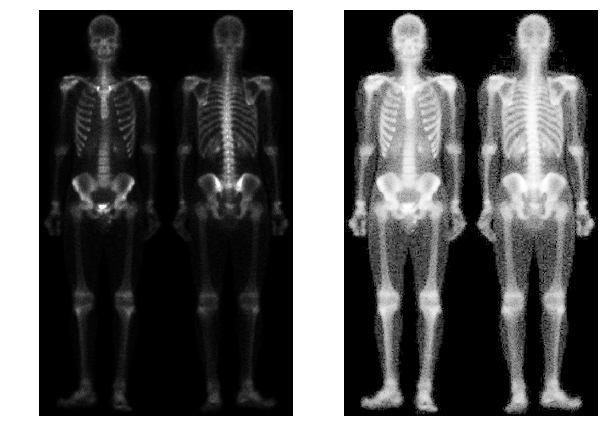

In [7]:
img = cv2.imread('./data/original_images/ch02/Fig0206(a).tif', cv2.IMREAD_ANYCOLOR)
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(121)
plt.imshow(img, cmap='gray')
plt.axis('off')

ax2 = fig.add_subplot(122)
tp_img = img / 255.0
plt.imshow(intrans(tp_img, 'stretch', np.mean(tp_img), 0.9), cmap='gray')
plt.axis('off')

plt.show()

+ 直方图均衡

In [8]:
img = cv2.imread('./data/original_images/ch02/Fig0208(a).tif', cv2.IMREAD_ANYCOLOR)

In [9]:
def im_histogram_equalization(img):
    cdp = get_cdp(imhist(img))
    h, w = img.shape
    tp_img = np.zeros([h, w], dtype=np.float32)
    for i in range(h):
        for j in range(w):
            tp_img[i, j] = cdp[img[i, j]]
    return tp_img

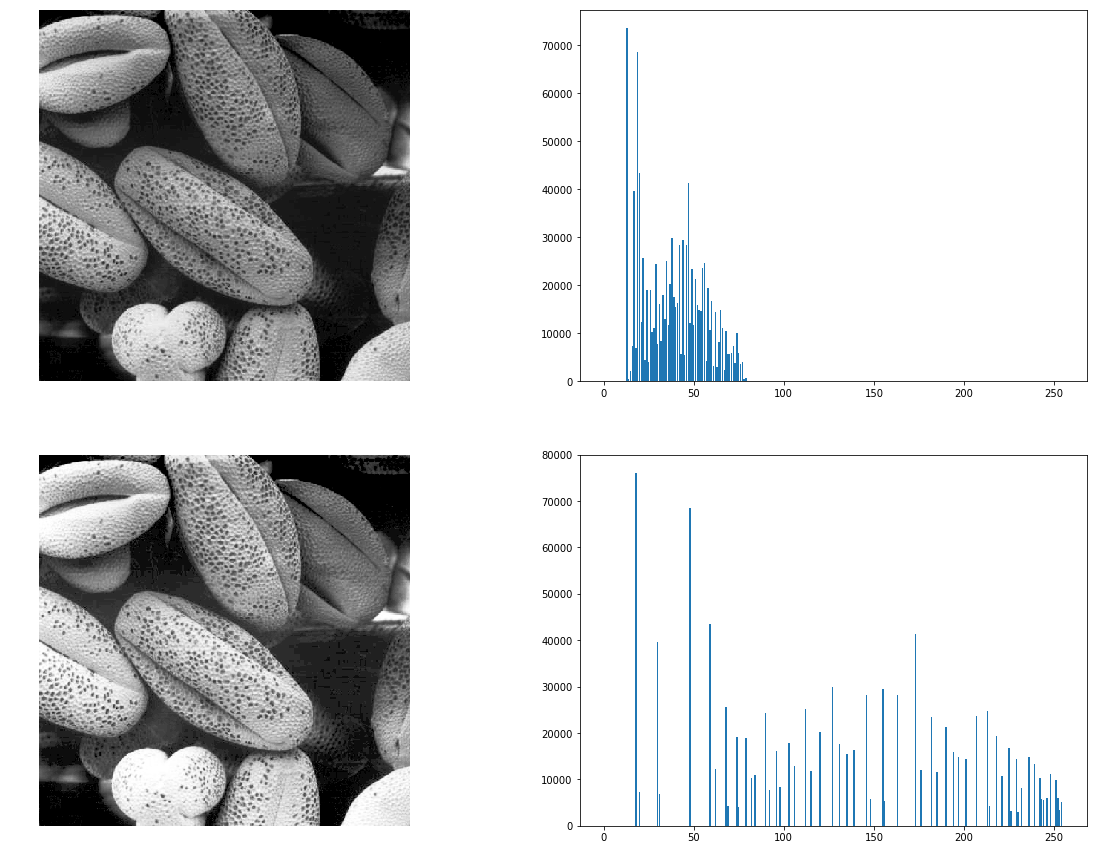

In [10]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1.imshow(img, cmap='gray')
ax1.axis('off')

ax2 = fig.add_subplot(222)
ax2.bar(np.arange(256), imhist(img))

ax3 = fig.add_subplot(223)
e_img = im_histogram_equalization(img)
ax3.imshow(e_img, cmap='gray')
ax3.axis('off')

ax4 = fig.add_subplot(224)
e_img = e_img * 255
e_img = e_img.astype(np.uint8)
ax4.bar(np.arange(256), imhist(e_img))

plt.show()